# TP3: Classification de modulation par deep learning

Listez les noms des étudiants (3 au maximum) ayant participé à ce notebook dans la cellule suivante (prénom, nom, affectation).<br/>
Au moment du rendu, le notebook doit être nommé nom1_nom2_dlts_tp3.ipynb 

Installez les paquets nécessaires à la réalisation de ce TP
<br> 
Vous pouvez utiliser dans le notebook 
!pip install \<nom_du_paquet\>

Helene Maxcici

Rajae Sebai

Imane

In [ ]:
!pip install matplotlib==3.4
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import matplotlib.pyplot as plt
import h5py 
import zipfile

import copy

import numpy as np 
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
from torchmetrics import Accuracy
import torch.nn.functional as F

from sklearn.metrics import confusion_matrix

## Données



L'objectif de ce projet est à partir de l'observation de 1024 échantillons d'un signal IQ de retrouver la modulation qui l'a constitué parmi: 
- BPSK
- PSK8
- QAM16
- QAM32
- QAM64
- QAM8
- QPSK

A chaque modulation nous avons associé un nombre entier identifiant:
{'BPSK': 0,
 'PSK8': 1,
 'QAM16': 2,
 'QAM32': 3,
 'QAM64': 4,
 'QAM8': 5,
 'QPSK': 6}

## Format

Les données sont distribuées dans trois fichiers indépendants: 
- augmod_train.hdf5
- augmod_valid.hdf5
- augmod_test.hdf5 

**L'ensemble de train est destiné à nourrir l'entraînement d'un réseau de neurones profond, l'ensemble de validation à monitorer l'évolution de métriques sur un ensemble indépendant durant un entraînement et l'ensemble de test est destiné à évaluer le modèle une fois entraîné.** 

Les trois jeux de données sont au format hdf5 qui peut être manipulé via l'API Python h5py https://docs.h5py.org/en/stable/quick.html.
Un fichier hdf5 est consitué d'une arborescence de datasets et de groups. Un dataset hdf5 représente un tenseur n dimensionnel. Un dataset se convertit très facilement en numpy array.
Un groupe peut contenir plusieurs datasets. Un groupe contient aussi un champs .attrs qui permet de regrouper des informations sous forme de dictionnaire. 

Un fichier de données D contient: 
- un groupe **'labels'** qui regroupe les correspondances nom_modulation -> id_modulation 
   - D['labels'].attrs[k] avec k dans D['labels'].attrs.keys() 
   - plus bas la fonction get_labels permet d'extraire ces correspondances sous forme d'un dictionnaire
- un dataset **'signal'**: **D['signal'] qui est de dimensions [N,2,1024] et contient N signaux IQ de 1024 échantillons**
- **un dataset 'snr': D['snr'] qui est de dimension [N], la composante  i codant le rapport signal sur bruit (en dB) du signal D['signal'][i,:,:]**

Les cellules suivantes donne un exemple d'ouverture d'un des fichiers de données: 

### Fonction utilitaire

In [ ]:
def get_labels(open_h5_file): 
    return {
        open_h5_file['labels'].attrs[k] : k
        for k in open_h5_file['labels'].attrs.keys()
    }

### Conversion directe en numpy

In [ ]:
!gdown "https://drive.google.com/uc?id=1Mz3OaR666K9Iqu1g97FFyIFQAhD74HCM&confirm=t"
with zipfile.ZipFile("/content/TP3 - Données et sujet-20221116.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/")

Downloading...
From: https://drive.google.com/uc?id=1Mz3OaR666K9Iqu1g97FFyIFQAhD74HCM&confirm=t
To: /content/TP3 - Données et sujet-20221116.zip
100% 656M/656M [00:03<00:00, 182MB/s]


In [ ]:
data_path = '/content/augmod_train.hdf5'

data = h5py.File(data_path , 'r')

signals = np.array(data['signals'])
snr =  np.array(data['snr'])
labels_id = np.array(data['type'])

labels_dict = get_labels(data)

data.close()

Il y a 87360 signaux, de dimensions (2,)



Le SNR du signal 1001 est 40.0
Le signal 1001 a pour id 1 il est de type PSK8


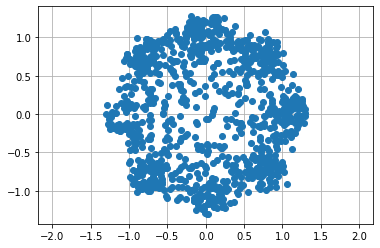

In [ ]:
print(f'Il y a {signals.shape[0]} signaux, de dimensions {signals.shape[1:2]}')
print('\n\n')

num_signal = 1001 

plt.figure()
print(f'Le SNR du signal {num_signal} est {snr[num_signal]}' )
print(f'Le signal {num_signal} a pour id {labels_id[num_signal]} il est de type {labels_dict[labels_id[num_signal]]}' )

plt.plot(signals[num_signal,0,:] , signals[num_signal,1,:],'o')
plt.axis('equal')
plt.grid()

### Utilisation des buffers hdf5 

Le SNR du signal 1001 est 40.0
Le signal 1001 a pour id 1 il est de type PSK8


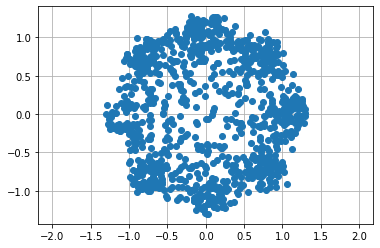

In [ ]:
data = h5py.File(data_path , 'r')

labels_dict = get_labels(data)


num_signal = 1001 

plt.figure()
print(f"Le SNR du signal {num_signal} est {data['snr'][num_signal]}" )
print(f'Le signal {num_signal} a pour id {labels_id[num_signal]} il est de type {labels_dict[labels_id[num_signal]]}' )

plt.plot(data['signals'][num_signal,0,:] , data['signals'][num_signal,1,:],'o')
plt.axis('equal')
plt.grid()


data.close()

## Objectifs du TP 

Pour ce TP vous devez 

1/ Visualiser les données d'entraînement, la distribution des types de modulations représentées dans l'ensemble de données et la distribution des SNR
2/ (optionnel) Proposer une méthode simple, 'baseline' pour l'identification de modulations
3/ Définir une ou plusieurs architectures de réseaux de neurones profonds et les implémenter en PyTorch
4/ Entrainer ces architectures, la fonction de perte employée pourra être la log vraisemblance négative: https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html. 
5/ Qualifier les performances de votre réseau de neurones sur l'ensemble de test via: 
   - Le calcul de l'accuracy implémentée par exemple dans le package TorchMetrics (https://torchmetrics.readthedocs.io/en/stable/classification/accuracy.html)
   - La réalisation d'un graphique accuracy vs SNR 
   - La réalisation des matrices de confusion entre les différentes classes pour un SNR de 10 dB (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix)

Durant l'entraînement on observera l'évolution de la fonction de perte et de l'accuracy sur l'ensemble d'entraînement et sur l'ensemble de validation. 

## 1. Visualization

In [ ]:
# Load data and convert to numpy
def load_data(data_path):
  # load file
  data = h5py.File(data_path , 'r')

  signals = np.array(data['signals'])
  snr =  np.array(data['snr'])
  labels_id = np.array(data['type'])

  data.close()

  return signals, snr, labels_id

folder_path = '/content/augmod_'

signals_train, snr_train, labels_id_train = load_data(folder_path+"train.hdf5")
signals_val, snr_val, labels_id_val = load_data(folder_path+"valid.hdf5")
signals_test, snr_test, labels_id_test = load_data(folder_path+"test.hdf5")

# load labels dict
data = h5py.File(folder_path+"train.hdf5" , 'r')
abels_dict = get_labels(data)
data.close()

Text(0.5, 0.98, 'Samples of Signals per Modulation')

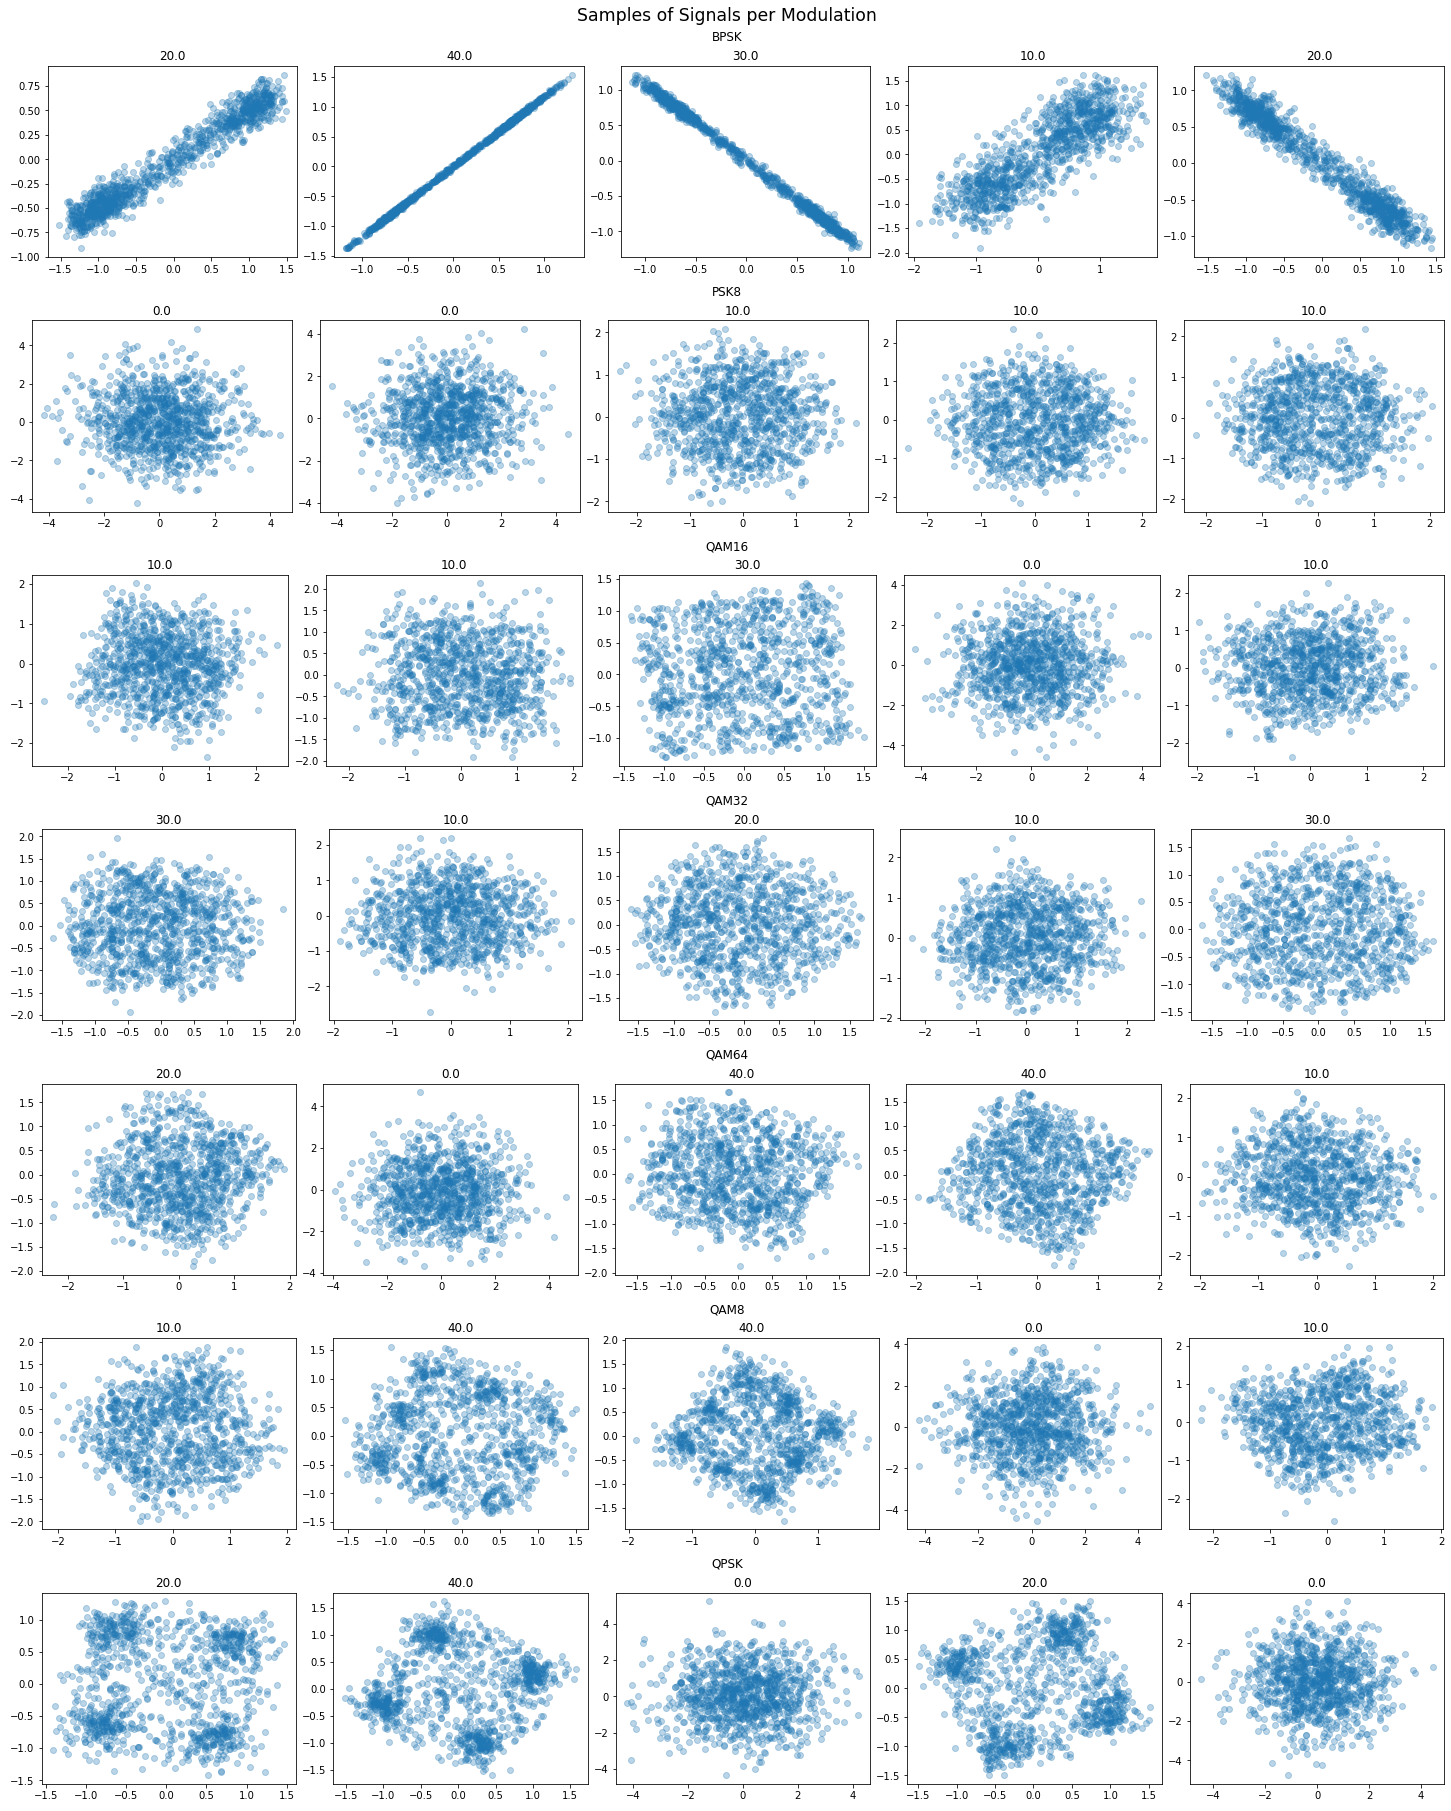

In [ ]:
fig = plt.figure(constrained_layout = True, figsize=(20,25))
subfigs = fig.subfigures(ncols = 1, nrows =len(labels_dict) )

for i, (label_id, name) in enumerate(labels_dict.items()):
  # Get signals of the label_id
  idx = np.argwhere(labels_id_train == label_id).ravel()
  # Pick randomly 5 samples
  idx_random = np.random.choice(idx, size = 5)
  # Visualize the signals
  axes = subfigs[i].subplots(ncols = 5)
  for j, signal_num in enumerate(idx_random):
    axes[j].scatter(signals_train[signal_num, 0, :], signals[signal_num, 1, :], 
                      alpha = 0.3)
    #axes[j].set_ylim(bottom = -1.5, top = 1.5)
    #axes[j].set_xlim(left = -1.5, right = 1.5)
    axes[j].set_title(snr[signal_num])
  subfigs[i].suptitle(name)
fig.suptitle("Samples of Signals per Modulation", fontsize = "xx-large")

# Model

We chose to implement a 1D CNN inspired by the Resnet architectures. That is, the model is composed of a stack of residual blocks, where each block consists of two sets of a 1D Convolution Layer, a 1D Batch Normalization and a ReLU. The residual connection in also a 1D Convolution Layer that adapts the input to the block to fit the size of its output. And between each block, there's a MaxPool layer.

We incrementally increased the complexity of the model by adding more blocks and increasing the number of filters in each layer, until we found the best model.

We also tried applying data augementation with 4 types of transformations:
1. **Rotation:** Rotate the symbols around the origin. Which is equivalent to varying the phase.
2. **Permutation:** Permute the sequence of symbols to create a new sequence easily.
3. **Roll:** Shift the sequence of symbols to creatse a new sequence.
4. **Noise:** Add Gaussian noise.

However, not all augmentations were benificial to the training. Rotating the signal symbols increased a bit the result. But, for permutation, although it should help the model generalize better, it was found that when we permutate the training signals with high probability the model yield lower performances. After several tries, and basing our decisions on the validation accuracy, we chose only to go with the rotations. 




In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Fix seeds
torch.manual_seed(0)
np.random.seed(0)

cuda:0


### Augmentation Function

In [ ]:
def augment_signal(signal, rotate_max = 0, permute = 0, roll=0, snr_min = None):
  """
  Applies augmentation on a single signal
  - rotation: max angle to rotate. If None, no rotation applied
  - permute: permutation probability, permute the symbols in the sequence
  - roll: probability of shifting symbols in time
  - snr: Add guassian noise according to SNR in dB
  """
  signal = signal.copy()
  if rotate_max > 0:
    # rotate signal by angle 
    angle = np.random.uniform(low = -rotate_max, high = rotate_max, size = 1)
    x, y = np.copy(signal)
    signal[0,:] = np.cos(angle) * x - np.sin(angle) * y
    signal[1,:] = np.sin(angle) * x + np.cos(angle) * y

  if permute > 0:
    p = np.random.uniform(size = 1)
    if p < permute:
      # symbol permutation in sequence
      indx_perm = np.random.permutation(signal.shape[-1])
      signal = signal[:, indx_perm]

  if roll > 0:
    p = np.random.uniform(size = 1)
    if p < permute:
      shift = np.random.randint(len(signal)//2)
      signal = np.roll(signal, shift)

  if snr_min is not None:
    snr = np.random.uniform(low = snr_min, high = 50, size = 1)
    # add gaussian noise
    Psignal = (signal**2).mean()
    Pnoise = Psignal/(10**(snr/10))
    signal[0] = signal[0] +  np.random.normal(loc = 0, scale = np.sqrt(Pnoise), 
                               size = signal.shape[-1] )
    signal[1] = signal[1] +  np.random.normal(loc = 0, scale = np.sqrt(Pnoise), 
                               size = signal.shape[-1] )

  return signal


### Customized Dataset

In [ ]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, signals, labels, snr, augment = False, transforms = None):
    self.signals = signals
    self.labels = labels
    self.snr = snr
    self.augment = augment
    self.transforms = transforms

  def __getitem__(self, index):
    signal = self.signals[index]

    if self.augment and self.transforms is not None:
      if self.snr[index] <= 20:
        snr_min = None
      else:
        snr_min = self.transforms["snr_min"]
      signal = augment_signal(signal, self.transforms["rotate_max"],
                            permute = self.transforms["permute"],
                            snr_min = snr_min)
      
    return index, signal, self.labels[index]
  
  def __len__(self):
    return len(self.signals)
    

In [ ]:
# Init Datasets
dataset_train = Dataset(signals_train, labels_id_train, snr_train, 
                        augment = False,
                        transforms = {"rotate_max": 0,
                                      "permute": 0,
                                      "snr_min": None})
dataset_val = Dataset(signals_val, labels_id_val, snr_val)
dataset_test = Dataset(signals_test, labels_id_test, snr_test)

#### Check and visualize augmentations

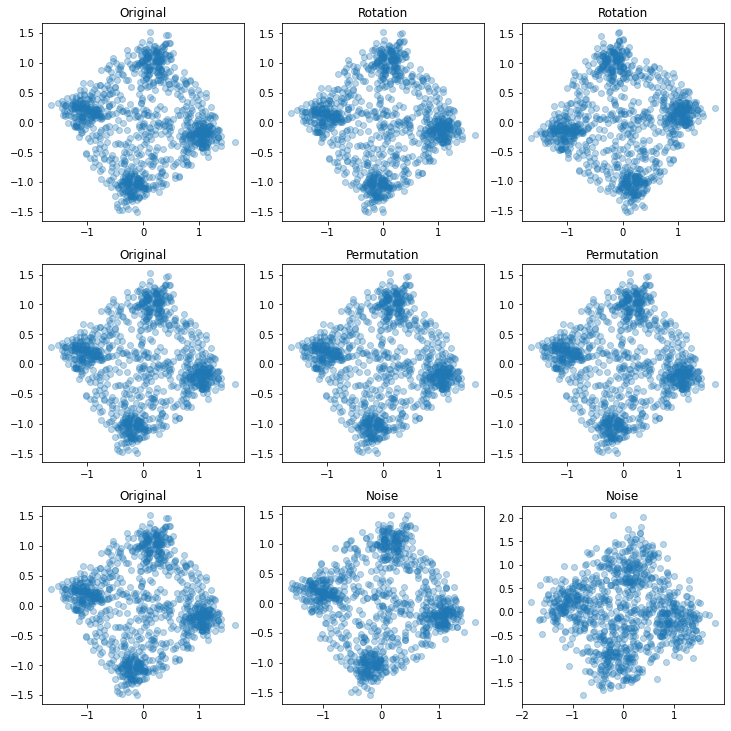

In [ ]:
fig = plt.figure(constrained_layout = True, figsize=(10,10))
subfigs = fig.subfigures(ncols = 1, nrows = 3)

dataset_train.augment = False
signal_id, signal, label = dataset_train[np.argwhere(snr_train == 40)[0,0]]

# Rotation
axes = subfigs[0].subplots(ncols = 3)
axes[0].scatter(signal[0], signal[1], alpha = 0.3)
axes[0].set_title("Original")
dataset_train.transforms= {"rotate_max": np.pi/4,"permute": 0,
                           "snr_min": None}
dataset_train.augment = True
for i in range(2):
  signal_id, signal, label = dataset_train[signal_id]
  axes[i+1].scatter(signal[0], signal[1], alpha = 0.3)
  axes[i+1].set_title("Rotation")

# Permutation
dataset_train.augment = False
signal= dataset_train[signal_id][1]

axes = subfigs[1].subplots(ncols = 3)
axes[0].scatter(signal[0], signal[1], alpha = 0.3)
axes[0].set_title("Original")
dataset_train.transforms= {"rotate_max": 0,"permute": 1,
                           "snr_min": None}
dataset_train.augment = True
for i in range(2):
  signal_id, signal, label = dataset_train[signal_id]
  axes[i+1].scatter(signal[0], signal[1], alpha = 0.3)
  axes[i+1].set_title("Permutation")

# Noise
# Permutation
dataset_train.augment = False
signal= dataset_train[signal_id][1]

axes = subfigs[2].subplots(ncols = 3)
axes[0].scatter(signal[0], signal[1], alpha = 0.3)
axes[0].set_title("Original")
dataset_train.transforms= {"rotate_max": 0,"permute": 0,
                           "snr_min": 5}
dataset_train.augment = True
for i in range(2):
  signal_id, signal, label = dataset_train[signal_id]
  axes[i+1].scatter(signal[0], signal[1], alpha = 0.3)
  axes[i+1].set_title("Noise")

In [ ]:
class CNN_1(nn.Module):
  def __init__(self, in_channels, n_classes, input_len):
    super().__init__()
    n_channels_1 = 32
    n_channels_2 = 128
    n_channels_3 = 64

    self.block1 = nn.Sequential(
        nn.Conv1d(in_channels = in_channels, out_channels = n_channels_1,
                                kernel_size = 7, padding = "same", groups = 1),
        nn.BatchNorm1d(n_channels_1),
        nn.ReLU(inplace = True),

        nn.Conv1d(in_channels = n_channels_1, out_channels = n_channels_1,
                                kernel_size = 7, padding = "same", groups = 1),
        nn.BatchNorm1d(n_channels_1),
        nn.ReLU(inplace = True),
    )
    self.residual1 = nn.Conv1d(in_channels = in_channels, out_channels = 1, 
                              kernel_size = 1)

    self.maxpool1 = nn.MaxPool1d(kernel_size = 2, stride = 2)

    self.block2 = nn.Sequential(
        nn.Conv1d(in_channels = n_channels_1, out_channels = n_channels_2,
                                kernel_size = 5, padding = "same", groups = 1),
        nn.BatchNorm1d(n_channels_2),
        nn.ReLU(inplace = True),

        nn.Conv1d(in_channels = n_channels_2, out_channels = n_channels_2,
                                kernel_size = 5, padding = "same", groups = 1),
        nn.BatchNorm1d(n_channels_2),
        nn.ReLU(inplace = True),
    )
    self.residual2 = nn.Sequential(
        nn.Conv1d(in_channels = n_channels_1, out_channels = 1, 
                              kernel_size = 1),
    )
    self.maxpool2 = nn.MaxPool1d(kernel_size = 2, stride = 2)

    self.block3 = nn.Sequential(
        nn.Conv1d(in_channels = n_channels_2, out_channels = n_channels_3,
                                kernel_size = 3, padding = "same", groups = 1),
        nn.BatchNorm1d(n_channels_3),
        nn.ReLU(inplace = True),

        nn.Conv1d(in_channels = n_channels_3, out_channels = n_channels_3,
                                kernel_size = 3, padding = "same", groups = 1),
        nn.BatchNorm1d(n_channels_3),
        nn.ReLU(inplace = True),
    )
    self.residual3 = nn.Sequential(
        nn.Conv1d(in_channels = n_channels_2, out_channels = 1, 
                              kernel_size = 1),
    )
    self.maxpool3 = nn.MaxPool1d(kernel_size = 2, stride = 2)

    self.avgpool = nn.Conv1d(in_channels = n_channels_3, out_channels = n_channels_3 *2,
                                kernel_size = input_len//(2**3), 
                                groups = n_channels_3)

    # Linear
    self.linear = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = n_channels_3 *2, 
                  out_features = n_classes),
          
        nn.LogSoftmax(dim = 1)
    )

  def forward(self, s):

    f1 = self.block1(s)
    res1 = self.residual1(s)
    f1 = self.maxpool1(F.relu(f1+res1))

    f2 = self.block2(f1)
    res2 = self.residual2(f1)
    f2 = self.maxpool2(F.relu(f2+res2))

    f3 = self.block3(f2)
    res3 = self.residual3(f2)
    f3 = self.maxpool3(F.relu(f3+res3)) 

    f4 = self.avgpool(f3)

    o = self.linear(f4)
    return o

In [ ]:
class Trainer:
  def __init__(self, model, criterion, optimizer, device):
    # set model
    self.model = model
    # set optim
    self.criterion = criterion
    self.optimizer = optimizer

    self.device = device

  def train(self, datasetr_train, dataset_val, n_epochs, batch_size,
            augment = False ):

    # prep dataloader
    dataloader_train = torch.utils.data.DataLoader(dataset_train, 
                                               batch_size = batch_size,
                                               shuffle = True)
    # save augment choice
    self.augment_init = augment
    dataset_train.augment = augment  

    # init curves
    self.losses_train = []
    self.losses_val = []
    self.acc_train = []
    self.acc_val = []

    best_acc_val = 0

    # start training
    for i_epoch in range(n_epochs):
      
      for i_batch, (ids, signals, labels) in enumerate(tqdm(dataloader_train)):
        
        self.model.train()
        
        # data to gpu
        signals = signals.float().to(self.device)
        labels = labels.long().to(self.device)

        # zero grads
        self.optimizer.zero_grad()

        # forward 
        scores = self.model(signals)
        loss = self.criterion(scores, labels)
        loss.backward()

        self.optimizer.step( )
      
      scheduler.step()

      # evaluate training set
      dataset_train.augment = False
      scores_train, loss_train = self.predict(dataset_train)
      preds_train = torch.argmax(scores_train, dim = 1)
      acc_train = accuracy(preds_train, torch.from_numpy(dataset_train.labels))
      self.losses_train.append(loss_train)
      self.acc_train.append(acc_train)
      # return to initial settings
      dataset_train.augment = self.augment_init
      
      # evaluate validation set
      scores_val, loss_val = self.predict(dataset_val)
      preds_val = torch.argmax(scores_val, dim = 1)
      acc_val = accuracy(preds_val, torch.from_numpy(dataset_val.labels))
      self.losses_val.append(loss_val)
      self.acc_val.append(acc_val)

      print(f"EPOCH {i_epoch + 1:3d}| TRAIN - loss:{loss_train:<5.3f}"
            f" - acc_train:{acc_train*100:<10.3f}"
            f" - acc_val:{acc_val*100:<10.3f}")
      
      # Save best model
      if acc_val > best_acc_val:
        self.best_model = copy.deepcopy(self.model)
        best_acc_val = acc_val
        print("Saved model as best.")

  def predict(self, dataset, return_labels = False):
    """
    Evaluates the model i.e. returns scores and loss for the given dataset
    """
    # prep dataloader
    dataloader = torch.utils.data.DataLoader(dataset, batch_size = 256, 
                                             shuffle = False)
    
    # init curves
    scores = []
    labels = []
    loss = 0

    # evaluate
    for ids_batch, signals_batch, labels_batch in dataloader:
      self.model.eval()
      
      # data to gpu
      signals_batch = signals_batch.float().to(device)
      labels_batch = labels_batch.long().to(device)   

      # forward 
      with torch.no_grad():
        scores_batch = model(signals_batch)
      # loss
      loss += criterion(scores_batch, labels_batch).item()

      labels.append(labels_batch.cpu())
      scores.append(scores_batch.cpu())

    if return_labels:
      return torch.cat(scores), loss/len(dataloader), torch.cat(labels)

    return torch.cat(scores), loss/len(dataloader)


In [ ]:
# instantiate model
in_channels = signals_train.shape[1]
n_classes = len(labels_dict)
model = CNN_1(in_channels = in_channels, n_classes = n_classes, 
              input_len = signals_train.shape[-1])
model = model.to(device)

In [ ]:
# hyperparam
batch_size = 64
lr = 5e-4

# dataloader

# prep optimization
optimizer = torch.optim.Adam(params = model.parameters(), lr = lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, 
                                      milestones=[5, 10, 15, 20, 25], gamma=0.6,
                                      verbose = True)
criterion = nn.NLLLoss().to(device)
# prep metrics
accuracy = Accuracy(task = "multiclass", num_classes = len(labels_dict))

Adjusting learning rate of group 0 to 5.0000e-04.


In [ ]:
dataset_train.transforms={"rotate_max": np.pi/4, "permute": 0,
                           "snr_min": None, "roll": 0}

In [ ]:
trainer = Trainer(model, criterion, optimizer, device)

In [ ]:
trainer.train(dataset_train, dataset_val, 30, batch_size, augment = True)

  0%|          | 0/1365 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-04.
EPOCH   1| TRAIN - loss:0.770 - acc_train:64.754     - acc_val:64.146    
Saved model as best.


  0%|          | 0/1365 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-04.
EPOCH   2| TRAIN - loss:0.630 - acc_train:74.175     - acc_val:73.242    
Saved model as best.


  0%|          | 0/1365 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-04.
EPOCH   3| TRAIN - loss:0.607 - acc_train:73.162     - acc_val:72.537    


  0%|          | 0/1365 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-04.
EPOCH   4| TRAIN - loss:0.423 - acc_train:81.837     - acc_val:80.913    
Saved model as best.


  0%|          | 0/1365 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.0000e-04.
EPOCH   5| TRAIN - loss:0.422 - acc_train:82.173     - acc_val:80.600    


  0%|          | 0/1365 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.0000e-04.
EPOCH   6| TRAIN - loss:0.372 - acc_train:84.501     - acc_val:82.289    
Saved model as best.


  0%|          | 0/1365 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.0000e-04.
EPOCH   7| TRAIN - loss:0.379 - acc_train:83.835     - acc_val:81.772    


  0%|          | 0/1365 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.0000e-04.
EPOCH   8| TRAIN - loss:0.368 - acc_train:84.606     - acc_val:82.095    


  0%|          | 0/1365 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.0000e-04.
EPOCH   9| TRAIN - loss:0.345 - acc_train:85.859     - acc_val:82.692    
Saved model as best.


  0%|          | 0/1365 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.8000e-04.
EPOCH  10| TRAIN - loss:0.445 - acc_train:82.434     - acc_val:80.185    


  0%|          | 0/1365 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.8000e-04.
EPOCH  11| TRAIN - loss:0.371 - acc_train:84.845     - acc_val:81.994    


  0%|          | 0/1365 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.8000e-04.
EPOCH  12| TRAIN - loss:0.326 - acc_train:86.948     - acc_val:82.834    
Saved model as best.


  0%|          | 0/1365 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.8000e-04.
EPOCH  13| TRAIN - loss:0.319 - acc_train:87.055     - acc_val:82.782    


  0%|          | 0/1365 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.8000e-04.
EPOCH  14| TRAIN - loss:0.306 - acc_train:87.814     - acc_val:82.937    
Saved model as best.


  0%|          | 0/1365 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0800e-04.
EPOCH  15| TRAIN - loss:0.304 - acc_train:87.983     - acc_val:82.965    
Saved model as best.


  0%|          | 0/1365 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0800e-04.
EPOCH  16| TRAIN - loss:0.292 - acc_train:88.522     - acc_val:83.127    
Saved model as best.


  0%|          | 0/1365 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0800e-04.
EPOCH  17| TRAIN - loss:0.288 - acc_train:88.697     - acc_val:82.953    


  0%|          | 0/1365 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0800e-04.
EPOCH  18| TRAIN - loss:0.283 - acc_train:88.997     - acc_val:83.114    


  0%|          | 0/1365 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0800e-04.
EPOCH  19| TRAIN - loss:0.279 - acc_train:89.199     - acc_val:82.951    


  0%|          | 0/1365 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.4800e-05.
EPOCH  20| TRAIN - loss:0.274 - acc_train:89.554     - acc_val:82.903    


  0%|          | 0/1365 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.4800e-05.
EPOCH  21| TRAIN - loss:0.269 - acc_train:89.729     - acc_val:83.027    


  0%|          | 0/1365 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.4800e-05.
EPOCH  22| TRAIN - loss:0.265 - acc_train:89.961     - acc_val:82.960    


  0%|          | 0/1365 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.4800e-05.
EPOCH  23| TRAIN - loss:0.256 - acc_train:90.395     - acc_val:82.981    


  0%|          | 0/1365 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.4800e-05.
EPOCH  24| TRAIN - loss:0.255 - acc_train:90.524     - acc_val:82.944    


  0%|          | 0/1365 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.8880e-05.
EPOCH  25| TRAIN - loss:0.258 - acc_train:90.314     - acc_val:82.871    


  0%|          | 0/1365 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.8880e-05.
EPOCH  26| TRAIN - loss:0.249 - acc_train:90.733     - acc_val:83.001    


  0%|          | 0/1365 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.8880e-05.
EPOCH  27| TRAIN - loss:0.246 - acc_train:90.853     - acc_val:82.958    


  0%|          | 0/1365 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.8880e-05.
EPOCH  28| TRAIN - loss:0.243 - acc_train:90.984     - acc_val:82.914    


  0%|          | 0/1365 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.8880e-05.
EPOCH  29| TRAIN - loss:0.243 - acc_train:91.057     - acc_val:82.859    


  0%|          | 0/1365 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.8880e-05.
EPOCH  30| TRAIN - loss:0.237 - acc_train:91.369     - acc_val:82.992    


In [ ]:
trainer.model = trainer.best_model

### Training Curves

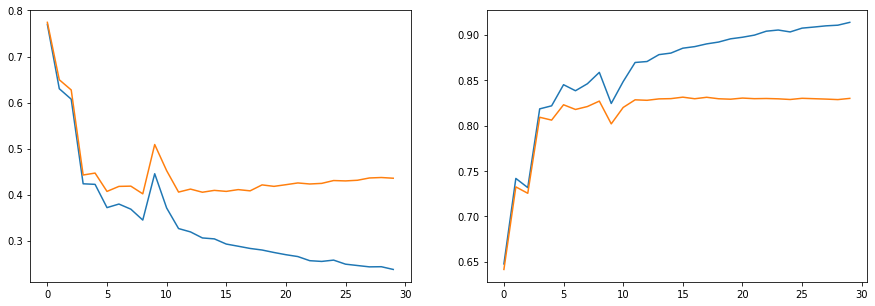

In [ ]:
plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
plt.plot(trainer.losses_train)
plt.plot(trainer.losses_val)

plt.subplot(1,2,2)
plt.plot(trainer.acc_train)
plt.plot(trainer.acc_val)

### Evaluate on Test set

In [ ]:
scores_test, loss_test = trainer.predict(dataset_test)
acc_test = accuracy(scores_test, torch.from_numpy(dataset_test.labels))
print("Test accuracy: ", acc_test)

Test accuracy:  tensor(0.8257)


### Accuracy vs SNR

In [ ]:
snr_set = np.unique(snr_test)

accuracies  = []

for snr in snr_set:
  mask_snr = (snr_test == snr)
  dataset_snr =  Dataset(signals_test[mask_snr], labels_id_test[mask_snr], 
                         snr_test[mask_snr])
  scores_test, loss_test = trainer.predict(dataset_snr)
  acc_test = accuracy(scores_test, torch.from_numpy(dataset_snr.labels))
  accuracies.append(acc_test.item())

Text(0.5, 0, 'SNR')

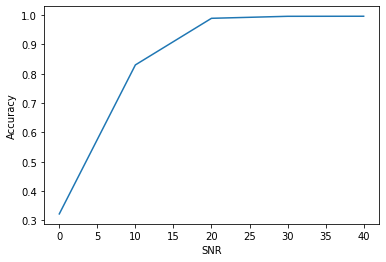

In [ ]:
plt.plot(snr_set, accuracies)
plt.ylabel("Accuracy")
plt.xlabel("SNR")

**Comment:** We can see that for high SNR (40dB), the model classifies the signals perfectly with an accuracy of 100%. As the SNR decreases, the accuracy gets lower, to reach 30% only for an SNR of 0dB. This is reasonable since for an SNR of 0dB we have as much noise as the signal, which makes it very hard, even for us as humans to classify. For that, the model can't learn from these very noisy signals, and at some point it starts overfitting by memorizing their noise.

## Confusion Matrix

In [ ]:
mask_10dB = (snr_test == 10)
dataset_10dB =  Dataset(signals_test[mask_10dB], labels_id_test[mask_10dB], 
                         snr_test[mask_10dB])
scores_test, loss_test = trainer.predict(dataset_10dB)
y_test_pred = np.argmax(scores_test, axis = 1)

In [ ]:
labels_dict.values

<function dict.values>

<AxesSubplot:>

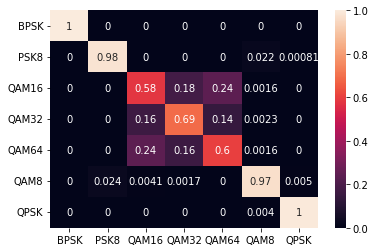

In [ ]:
cm = confusion_matrix(dataset_10dB.labels, y_test_pred, normalize = "true")
df = pd.DataFrame(data = cm, columns = labels_dict.values(), index = labels_dict.values())
sns.heatmap(df, annot=True)

**Comment:** We can notice that the confusion is high between QAM16, QAM32 and QAM64.  These higher orders of QAM can be used to gain a faster data rate, however they are less robust to noise. As the QAM order increases, the distance between the different symbols decreases. Thus, for a same signal power, the same SNR deteriorates more high orders QAM. Which is also visible in the visualization of the data above.